In [ ]:
import pandas as pd
from scipy.stats import binomtest

# Load the dataset
gender_df = pd.read_csv('/Data/target_gender_ads.csv', index_col=False) #gender


# Count correct predictions overall
gender_df['correct'] = gender_df['true_gender'] == gender_df['predicted_gender']
num_correct = gender_df['correct'].sum()
num_total = len(gender_df)

# Perform a binomial test
# Null hypothesis: probability of correct prediction is 0.5 (random guessing)
binom_result = binomtest(num_correct, n=num_total, p=0.5, alternative='greater')

# Prepare results
{
    "Total Predictions": num_total,
    "Correct Predictions": num_correct,
    "Accuracy": num_correct / num_total,
    "p-value": binom_result.pvalue,
    "Conclusion": "Reject H0" if binom_result.pvalue < 0.05 else "Fail to Reject H0"
}


{'Total Predictions': 106,
 'Correct Predictions': 96,
 'Accuracy': 0.9056603773584906,
 'p-value': 4.371415399785488e-19,
 'Conclusion': 'Reject H0'}

In [ ]:
age_df = pd.read_csv('/Data/target_age_ads.csv', index_col=False) #age

# Use the correct column names based on the CSV file
age_df['correct'] = age_df['true_age_group'] == age_df['predicted_age_group']
num_correct_age = age_df['correct'].sum()
num_total_age = len(age_df)

# Perform a binomial test with p=0.25 (random chance for 4 age groups)
binom_result_age = binomtest(num_correct_age, n=num_total_age, p=0.25, alternative='greater')

# Prepare and return results
{
    "Total Predictions": num_total_age,
    "Correct Predictions": num_correct_age,
    "Accuracy": num_correct_age / num_total_age,
    "p-value": binom_result_age.pvalue,
    "Conclusion": "Reject H0" if binom_result_age.pvalue < 0.05 else "Fail to Reject H0"
}


{'Total Predictions': 121,
 'Correct Predictions': 104,
 'Accuracy': 0.859504132231405,
 'p-value': 4.266942530265911e-45,
 'Conclusion': 'Reject H0'}

In [7]:
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
import pandas as pd


# Gender-based Z-test for TPR (positive class: female)
gender_df['is_correct'] = gender_df['true_gender'] == gender_df['predicted_gender']
female_df = gender_df[gender_df['true_gender'] == 'female']
male_df = gender_df[gender_df['true_gender'] == 'male']

# TPR: correct predictions among actual positives
female_tpr_count = female_df['is_correct'].sum()
female_total = len(female_df)

male_tpr_count = male_df['is_correct'].sum()
male_total = len(male_df)

# Z-test for gender TPR
gender_tpr_ztest = proportions_ztest([female_tpr_count, male_tpr_count], [female_total, male_total])
gender_tpr_ci = confint_proportions_2indep(female_tpr_count, female_total, male_tpr_count, male_total)

# Age-based Z-test (choose two representative groups: young vs senior)
age_df['is_correct'] = age_df['true_age_group'] == age_df['predicted_age_group']
young_df = age_df[age_df['true_age_group'] == 'Young']
senior_df = age_df[age_df['true_age_group'] == 'Senior']

young_tpr_count = young_df['is_correct'].sum()
young_total = len(young_df)

senior_tpr_count = senior_df['is_correct'].sum()
senior_total = len(senior_df)

# Z-test for age TPR
age_tpr_ztest = proportions_ztest([young_tpr_count, senior_tpr_count], [young_total, senior_total])
age_tpr_ci = confint_proportions_2indep(young_tpr_count, young_total, senior_tpr_count, senior_total)

{
    "Gender TPR Z-test": {
        "p-value": gender_tpr_ztest[1],
        "95% CI": gender_tpr_ci
    },
    "Age TPR Z-test (Young vs Senior)": {
        "p-value": age_tpr_ztest[1],
        "95% CI": age_tpr_ci
    }
}


{'Gender TPR Z-test': {'p-value': 0.08609407605250705,
  '95% CI': (-0.017692783819458394, 0.23029845839152768)},
 'Age TPR Z-test (Young vs Senior)': {'p-value': 0.0040270284218350836,
  '95% CI': (0.13838930964810897, 0.7958602027053414)}}

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import ace_tools_open as tools

# ---------- 1. Load data ----------
df = pd.read_csv('/Data/target_gender_ads.csv') #gender

# ---------- 2. Utility to convert spend / impressions dictionaries ----------
def _midpoint(val):
    """Return midpoint between lower & upper bound stored as a dict‐string."""
    try:
        rng = ast.literal_eval(val)
        lo = float(rng.get("lower_bound", "0").replace(",", ""))
        hi = float(rng.get("upper_bound", "0").replace(",", ""))
        return (lo + hi) / 2.0
    except Exception:
        return np.nan

df["ad_spend"] = df["spend"].apply(_midpoint)
df["impressions_est"] = df["impressions"].apply(_midpoint)

In [25]:
# ---------- 3. Strata definitions ----------
# (a) Ad‑spend: simple binary split at ≤ $50 vs > $50
df["spend_bin"] = np.where(df["ad_spend"] <= 50, "low", "high")

# (b) Topic cluster: TF‑IDF + k‑means (k = 5)
vectorizer = TfidfVectorizer(max_features=1_000, stop_words="english")
X = vectorizer.fit_transform(df["ad_creative_body"].fillna(""))
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
df["topic"] = kmeans.fit_predict(X)

In [26]:
# ---------- 4. Fairness metrics ----------
def _metrics(sub):
    n = len(sub)
    y_pred = (sub["predicted_gender"] == "male").astype(int)
    y_true = (sub["true_gender"] == "male").astype(int)
    sens = sub["true_gender"]  # sensitive attribute

    # selection rate per group
    sr_male = y_pred[sens == "male"].mean() if (sens == "male").any() else np.nan
    sr_female = (
        y_pred[sens == "female"].mean() if (sens == "female").any() else np.nan
    )
    demo_parity = sr_male - sr_female

    # accuracy per group
    acc_male = (y_pred[sens == "male"] == y_true[sens == "male"]).mean()
    acc_female = (y_pred[sens == "female"] == y_true[sens == "female"]).mean()
    acc_gap = acc_male - acc_female

    return pd.Series({"n": n, "demo_parity": demo_parity, "acc_gap": acc_gap})

In [27]:
# ---------- 5. Bootstrap CIs ----------
def _bootstrap(df, strat_col, B=500, alpha=0.05):
    out = []
    for s, sub in df.groupby(strat_col):
        point = _metrics(sub)
        demos, accs = [], []
        for _ in range(B):
            boot = sub.sample(len(sub), replace=True, random_state=None)
            m = _metrics(boot)
            demos.append(m["demo_parity"])
            accs.append(m["acc_gap"])
        demos = np.array(demos)
        accs = np.array(accs)
        out.append(
            {
                strat_col: s,
                "n": point["n"],
                "demo_parity": point["demo_parity"],
                "demo_lo": np.nanpercentile(demos, alpha / 2 * 100),
                "demo_hi": np.nanpercentile(demos, (1 - alpha / 2) * 100),
                "acc_gap": point["acc_gap"],
                "acc_lo": np.nanpercentile(accs, alpha / 2 * 100),
                "acc_hi": np.nanpercentile(accs, (1 - alpha / 2) * 100),
            }
        )
    return pd.DataFrame(out)


spend_tbl = _bootstrap(df, "spend_bin")
topic_tbl = _bootstrap(df, "topic")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Fairness by spend tier


Loading ITables v2.4.2 from the internet... (need help?)


Fairness by topic cluster


Loading ITables v2.4.2 from the internet... (need help?)


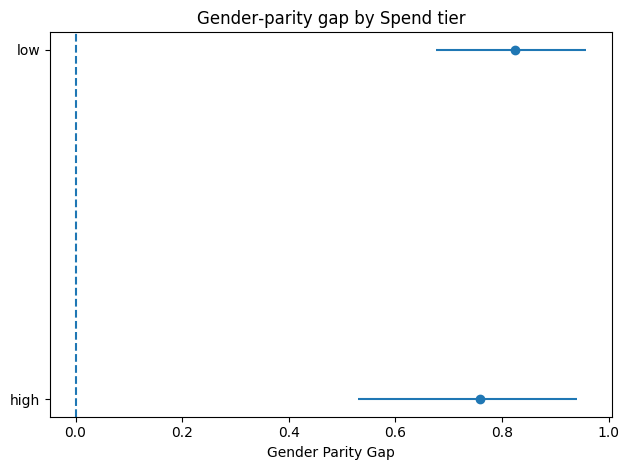

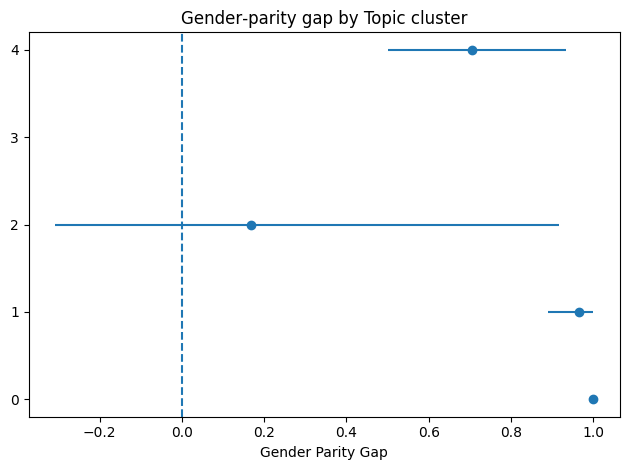

In [ ]:
# ---------- 6. Display tables ----------
import ace_tools_open as tools
tools.display_dataframe_to_user("Fairness by spend tier", spend_tbl)
tools.display_dataframe_to_user("Fairness by topic cluster", topic_tbl)

# ---------- 7. Forest plots ----------
def _forest(table, metric, lo, hi, title):
    fig, ax = plt.subplots()
    y_pos = np.arange(len(table))
    ax.errorbar(
        table[metric],
        y_pos,
        xerr=[
            table[metric] - table[lo],
            table[hi] - table[metric],
        ],
        fmt="o",
    )
    ax.set_yticks(y_pos)
    ax.set_yticklabels(table.iloc[:, 0])
    ax.axvline(0, linestyle="--")
    ax.set_xlabel("Gender Parity Gap")
    #ax.set_xlabel(metric.replace("_", " ").title())
    ax.set_title(title)
    plt.tight_layout()
    #plt.show()
    


_forest(spend_tbl, "demo_parity", "demo_lo", "demo_hi", "Gender‑parity gap by Spend tier")
plt.savefig('/Image/gender_parity_spend.png')
_forest(topic_tbl, "demo_parity", "demo_lo", "demo_hi", "Gender‑parity gap by Topic cluster")
plt.savefig('/Image/gender_parity_topic.png')

Age-parity by spend tier


Loading ITables v2.4.2 from the internet... (need help?)


Age-parity by topic cluster


Loading ITables v2.4.2 from the internet... (need help?)


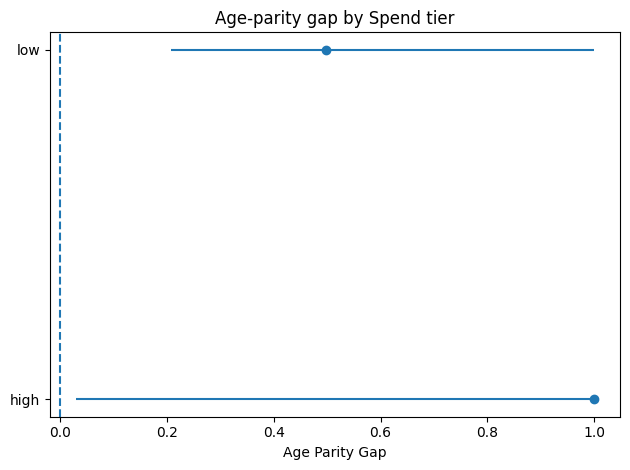

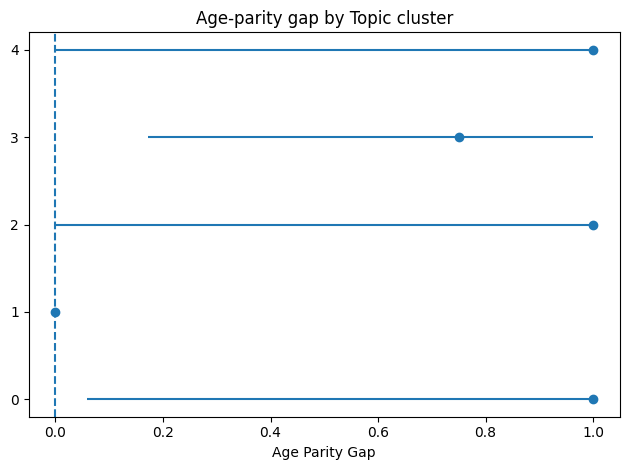

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import ace_tools_open as tools

# ---------- 1. Load data ----------
df_age = pd.read_csv('/Data/target_age_ads.csv') #age

# --- helper to convert spend fields stored as dict strings ---
def _midpoint(val):
    try:
        rng = ast.literal_eval(val)
        lo = float(rng.get("lower_bound", "0").replace(",", ""))
        hi = float(rng.get("upper_bound", "0").replace(",", ""))
        return (lo + hi) / 2.0
    except Exception:
        return np.nan

df_age["ad_spend"] = df_age["spend"].apply(_midpoint)
df_age["impressions_est"] = df_age["impressions"].apply(_midpoint)

# Strata
df_age["spend_bin"] = np.where(df_age["ad_spend"] <= 50, "low", "high")

vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df_age["ad_creative_body"].fillna(""))
df_age["topic"] = KMeans(n_clusters=5, random_state=42, n_init=10).fit_predict(X)

# --- metrics function (multi‑class age groups) ---
def _metrics_age(sub):
    sens = sub["true_age_group"]
    y_pred = sub["predicted_age_group"]
    sel_rates = {}
    acc_rates = {}
    for g in sens.unique():
        mask = sens == g
        sel_rates[g] = (y_pred[mask] == g).mean()
        acc_rates[g] = (y_pred[mask] == sens[mask]).mean()
    parity_gap = max(sel_rates.values()) - min(sel_rates.values())
    acc_gap = max(acc_rates.values()) - min(acc_rates.values())
    return pd.Series({"n": len(sub), "parity_gap": parity_gap, "acc_gap": acc_gap})

# --- bootstrap utility ---
def _bootstrap(df, strat_col, B=500, alpha=0.05):
    rows = []
    for s, sub in df.groupby(strat_col):
        point = _metrics_age(sub)
        parities, accs = [], []
        for _ in range(B):
            boot = sub.sample(len(sub), replace=True)
            m = _metrics_age(boot)
            parities.append(m["parity_gap"])
            accs.append(m["acc_gap"])
        parities = np.array(parities)
        accs = np.array(accs)
        rows.append({
            strat_col: s,
            "n": point["n"],
            "parity_gap": point["parity_gap"],
            "parity_lo": np.nanpercentile(parities, alpha/2*100),
            "parity_hi": np.nanpercentile(parities, (1-alpha/2)*100),
            "acc_gap": point["acc_gap"],
            "acc_lo": np.nanpercentile(accs, alpha/2*100),
            "acc_hi": np.nanpercentile(accs, (1-alpha/2)*100),
        })
    return pd.DataFrame(rows)

spend_tbl_age = _bootstrap(df_age, "spend_bin")
topic_tbl_age = _bootstrap(df_age, "topic")

tools.display_dataframe_to_user("Age-parity by spend tier", spend_tbl_age)
tools.display_dataframe_to_user("Age-parity by topic cluster", topic_tbl_age)

# --- forest plot helper ---
def _forest(tbl, metric, lo, hi, title, label_col):
    fig, ax = plt.subplots()
    y_pos = np.arange(len(tbl))
    ax.errorbar(tbl[metric], y_pos,
                xerr=[tbl[metric]-tbl[lo], tbl[hi]-tbl[metric]],
                fmt='o')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tbl[label_col])
    ax.axvline(0, linestyle="--")
    ax.set_xlabel("Age Parity Gap")
    #ax.set_xlabel(metric.replace("_", " ").title())
    ax.set_title(title)
    plt.tight_layout()
    #plt.show()

_forest(spend_tbl_age, "parity_gap", "parity_lo", "parity_hi", "Age‑parity gap by Spend tier", "spend_bin")
plt.savefig('/Image/age_parity_spend.png')
_forest(topic_tbl_age, "parity_gap", "parity_lo", "parity_hi", "Age‑parity gap by Topic cluster", "topic")
plt.savefig('/Image/age_parity_topic.png')

## Learning curve  plot

Learning‑curve metrics


Loading ITables v2.4.2 from the internet... (need help?)


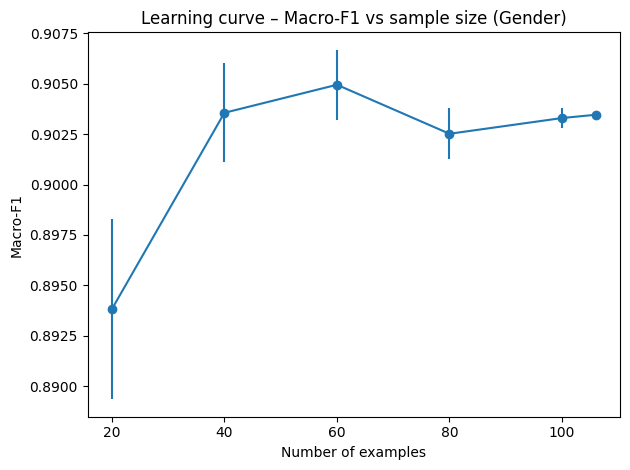

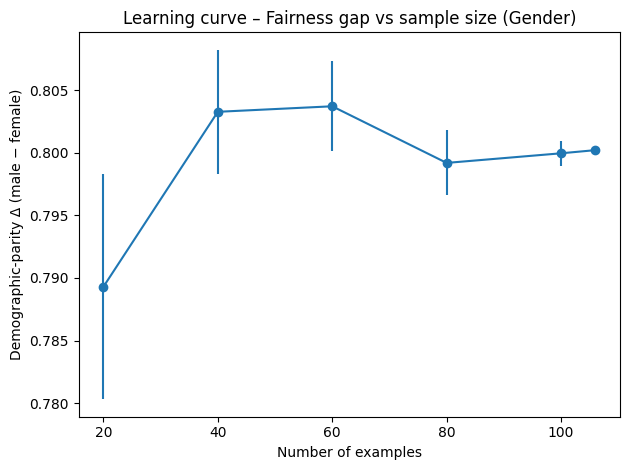

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import ast
import ace_tools_open as tools

# ---------- 1. Load gender‑target dataset ----------
df = pd.read_csv('/Data/target_gender_ads.csv') #gender

# Ensure needed columns exist
REQUIRED = {'true_gender', 'predicted_gender'}
missing = REQUIRED - set(df.columns)
assert not missing, f"Missing columns: {missing}"

# ---------- 2. Metric helpers ----------
def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def parity_gap(sub):
    sens = sub["true_gender"]
    y_pred = sub["predicted_gender"]
    sr_male = (y_pred[sens == "male"] == "male").mean()
    sr_female = (y_pred[sens == "female"] == "male").mean()
    return sr_male - sr_female

def compute_metrics(sample):
    return macro_f1(sample["true_gender"], sample["predicted_gender"]), parity_gap(sample)

# ---------- 3. Learning‑curve computation ----------
rng = np.random.default_rng(0)
max_n = len(df)
step = 20
sizes = list(range(step, max_n, step)) + [max_n]  # e.g., 20,40,…,N
reps = 200  # bootstrap reps

records = []
for n in sizes:
    f1_vals = []
    gap_vals = []
    for _ in range(reps):
        sample = df.sample(n, replace=False, random_state=rng.integers(1e9))
        f1, gap = compute_metrics(sample)
        f1_vals.append(f1)
        gap_vals.append(gap)
    records.append({
        "n": n,
        "macro_f1_mean": np.mean(f1_vals),
        "macro_f1_se": np.std(f1_vals, ddof=1) / np.sqrt(reps),
        "gap_mean": np.mean(gap_vals),
        "gap_se": np.std(gap_vals, ddof=1) / np.sqrt(reps),
    })

lc = pd.DataFrame(records)

# ---------- 4. Display table ----------
tools.display_dataframe_to_user("Learning‑curve metrics", lc)

# ---------- 5. Plot 1 – macro‑F1 ----------
plt.figure()
plt.errorbar(lc["n"], lc["macro_f1_mean"],
             yerr=lc["macro_f1_se"], marker="o")
plt.xlabel("Number of examples")
plt.ylabel("Macro‑F1")
plt.title("Learning curve – Macro‑F1 vs sample size (Gender)")
plt.tight_layout()
#plt.show()
plt.savefig('/Image/lr_F1vsSample_gender.png')

# ---------- 6. Plot 2 – Demographic‑parity gap ----------
plt.figure()
plt.errorbar(lc["n"], lc["gap_mean"],
             yerr=lc["gap_se"], marker="o")
plt.xlabel("Number of examples")
plt.ylabel("Demographic‑parity Δ (male − female)")
plt.title("Learning curve – Fairness gap vs sample size (Gender)")
plt.tight_layout()
#plt.show()
plt.savefig('/Image/lr_fairnessGapvsSample_gender.png')


Learning‑curve (age) metrics


Loading ITables v2.4.2 from the internet... (need help?)


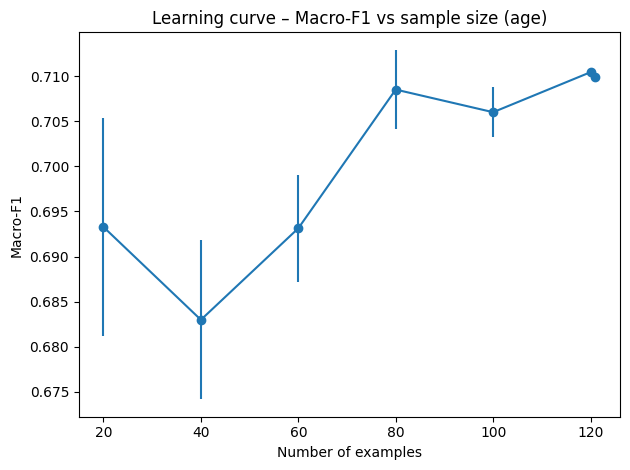

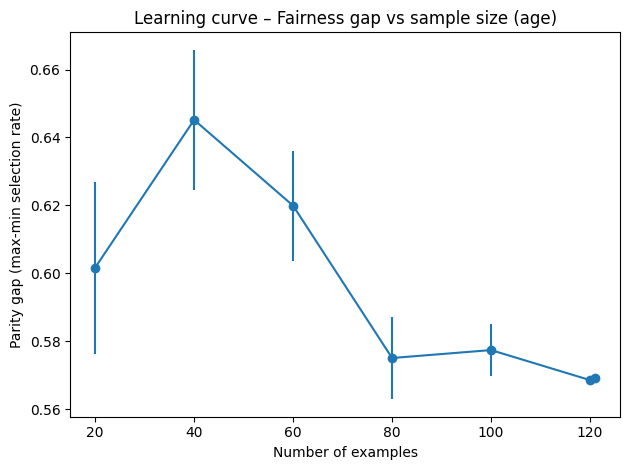

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import ace_tools_open as tools

# ---------- 1. Load age‑target dataset ----------
df_age = pd.read_csv('/Data/target_age_ads.csv') #age

# ---------- 2. Helper metrics ----------

def macro_f1_mc(y_true, y_pred):
    """Multi‑class macro F1."""
    return f1_score(y_true, y_pred, average="macro")

def age_parity_gap(sample):
    """Selection‑rate disparity across age groups: max − min."""
    y_true = sample["true_age_group"]
    y_pred = sample["predicted_age_group"]
    sel_rates = {}
    for grp in y_true.unique():
        mask = y_true == grp
        sel_rates[grp] = (y_pred[mask] == grp).mean()
    return max(sel_rates.values()) - min(sel_rates.values())

def compute_metrics(sample):
    return macro_f1_mc(sample["true_age_group"], sample["predicted_age_group"]), age_parity_gap(sample)

# ---------- 3. Learning‑curve parameters ----------
max_n = len(df_age)
step = 20
sizes = list(range(step, max_n, step)) + [max_n]  # e.g., 20,40,…,N
reps = 200
rng = np.random.default_rng(42)

records = []
for n in sizes:
    f1_vals = []
    gap_vals = []
    for _ in range(reps):
        sample = df_age.sample(n, replace=False, random_state=int(rng.integers(1e9)))
        f1, gap = compute_metrics(sample)
        f1_vals.append(f1)
        gap_vals.append(gap)
    records.append({
        "n": n,
        "macro_f1_mean": np.mean(f1_vals),
        "macro_f1_se": np.std(f1_vals, ddof=1) / np.sqrt(reps),
        "gap_mean": np.mean(gap_vals),
        "gap_se": np.std(gap_vals, ddof=1) / np.sqrt(reps)
    })

lc_age = pd.DataFrame(records)

# ---------- 4. Display table ----------
tools.display_dataframe_to_user("Learning‑curve (age) metrics", lc_age)

# ---------- 5. Plot macro‑F1 ----------
plt.figure()
plt.errorbar(lc_age["n"], lc_age["macro_f1_mean"],
             yerr=lc_age["macro_f1_se"], marker="o")
plt.xlabel("Number of examples")
plt.ylabel("Macro‑F1")
plt.title("Learning curve – Macro‑F1 vs sample size (age)")
plt.tight_layout()
#plt.show()
plt.savefig('/Image/lr_F1vsSample_age.png')

# ---------- 6. Plot parity gap ----------
plt.figure()
plt.errorbar(lc_age["n"], lc_age["gap_mean"],
             yerr=lc_age["gap_se"], marker="o")
plt.xlabel("Number of examples")
plt.ylabel("Parity gap (max‑min selection rate)")
plt.title("Learning curve – Fairness gap vs sample size (age)")
plt.tight_layout()
#plt.show()
plt.savefig('/Image/lr_fairnessGapvsSample_age.png')